## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.log_lower[0] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.log_upper[41] = log_upper

    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [2]:
import hinc
income_df = hinc.ReadData()

In [3]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

<ipython-input-1-9cb85983dd2d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.log_lower[0] = 3.0
<ipython-input-1-9cb85983dd2d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.log_upper[41] = log_upper


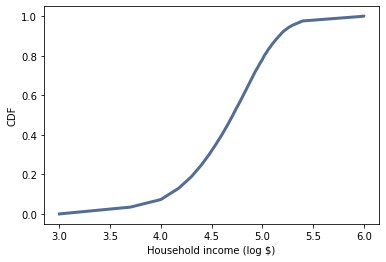

In [4]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [5]:
sample = np.power(10, log_sample)

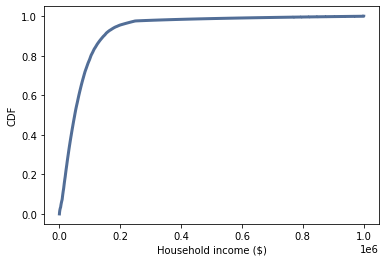

In [6]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [7]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

def Mean(xs):
    return RawMoment(xs, 1)

def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

def Skewness(xs):
    return StandardizedMoment(xs, 3)

def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp


In [8]:
print('Median: {}'.format(Median(sample)))
print('Mean: {}'.format(Mean(sample)))
print('Skewness: {}'.format(Skewness(sample)))
print('Pearson\'s skewness: {}'.format(PearsonMedianSkewness(sample)))
print('Fraction of households with income below the mean: {}'.format(cdf.Prob(Mean(sample))))

Median: 51226.45447894046
Mean: 74278.70753118733
Skewness: 4.949920244429583
Pearson's skewness: 0.7361258019141782
Fraction of households with income below the mean: 0.660005879566872


All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

*Skewness increases, but Pearson's median skewness decreases when the upper bound is changed to 10 million dollars.*

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

In [9]:
# Assuming the upper bound is 10 million dollars:
log_sample = InterpolateSample(income_df, log_upper=7.0)
sample = np.power(10, log_sample)
cdf = thinkstats2.Cdf(sample)

print('Median: {}'.format(Median(sample)))
print('Mean: {}'.format(Mean(sample)))
print('Skewness: {}'.format(Skewness(sample)))
print('Pearson\'s skewness: {}'.format(PearsonMedianSkewness(sample)))
print('Fraction of households with income below the mean: {}'.format(cdf.Prob(Mean(sample))))

<ipython-input-1-9cb85983dd2d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.log_lower[0] = 3.0
<ipython-input-1-9cb85983dd2d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.log_upper[41] = log_upper


Median: 51226.45447894046
Mean: 124267.39722164685
Skewness: 11.603690267537793
Pearson's skewness: 0.39156450927742087
Fraction of households with income below the mean: 0.8565630665207663
